<a href="https://colab.research.google.com/github/zahraaghapour/Image-Classification/blob/main/Flowers%20Classificstion/Flower_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image classification using Keras** 
*Flower Images*

## Import libraries

In [1]:
import os
import cv2
import pickle
import glob
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D,  MaxPooling2D, Dropout, Dense, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras import callbacks

from keras.applications import MobileNetV2, InceptionV3
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow


## Load Dataset

In [ ]:
!pip3 install --upgrade gdown
!gdown https://drive.google.com/uc?id=1hmty2zIv8F_D-Suuejn2DpHG0ubuIWtz
!unzip flowers

In [4]:
# Name of the flowers
data_dir = os.path.join(os.path.curdir, 'flowers/')
classes = sorted(os.listdir(data_dir))
num_calsses = len(classes)
print('Flowers: ',classes)

Flowers:  ['black_eyed_susan', 'calendula', 'california_poppy', 'common_daisy', 'coreopsis', 'sunflower']


In [5]:
# Variables
img_width = 128
img_height = 128
n_channels = 3
batch_size = 100
epochs = 80

## Extract Train and Test data

In [16]:
def extract_label_feature(images_path):
  data = []
  labels = []

  for img_path in images_path:
    image = cv2.imread(img_path)    # load image from file
    image = cv2.resize(image, (img_width,img_height))    # make all images to have a same size
    label = img_path.split(os.sep)[-2]       # Extract labels of the images from directory name
    labels.append(label)
    image = image/255
    data.append(image)

  # Encode string labels to numbers
  le = LabelEncoder()
  labels = le.fit_transform(labels)
  labels = keras.utils.to_categorical(labels, num_calsses)
  return np.array(data) , labels


img_list = glob.glob(f'{data_dir}/*/*.jpg')
train_path, test_path = train_test_split(img_list, test_size = 0.2)
train_x, train_y = extract_label_feature (train_path)
val_x, val_y = extract_label_feature (test_path)

# shape
print('train x shape : ',train_x.shape)
print('train y shape : ',train_y.shape)
print('test x shape : ',val_x.shape)
print('test y shape : ',val_y.shape)

train x shape :  (4843, 128, 128, 3)
train y shape :  (4843, 6)
test x shape :  (1211, 128, 128, 3)
test y shape :  (1211, 6)


## Display samples per class

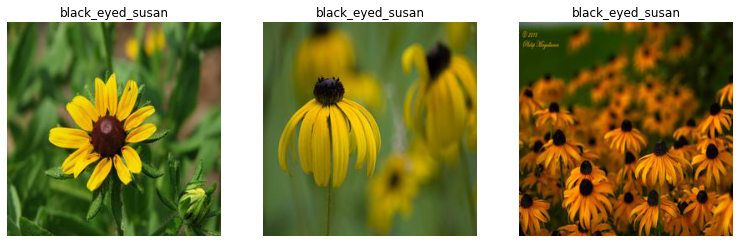

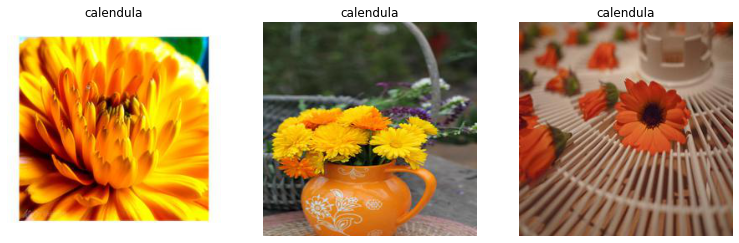

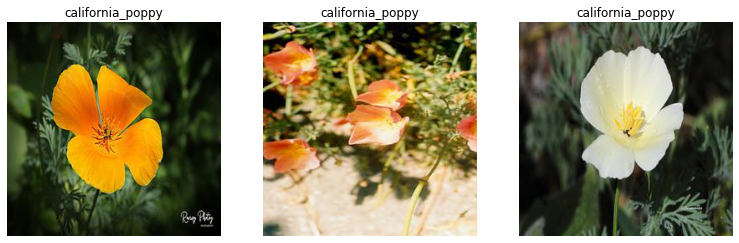

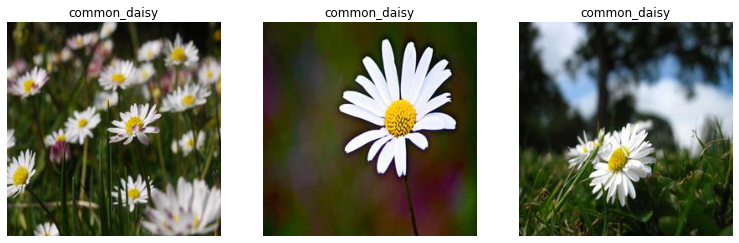

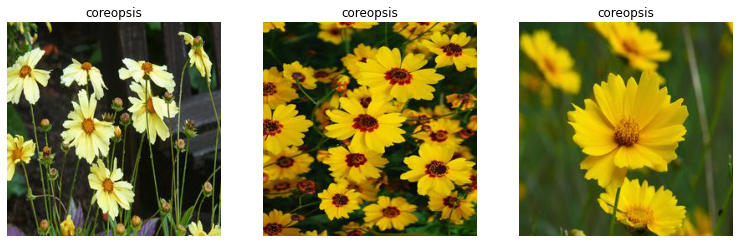

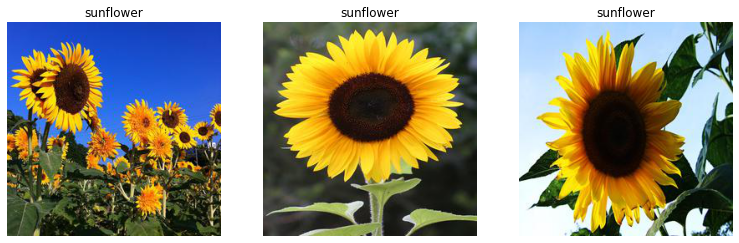

In [26]:
def load_random_imgs_from_folder(folder,label):
  plt.figure(figsize=(13,13))
  for i in range(3):
    file = np.random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img=plt.imread(image_path)
    ax=plt.subplot(1,3,i+1)
    ax.axis("off")
    ax.title.set_text(label)
    plt.imshow(img)


for label in classes:
    load_random_imgs_from_folder(f"{data_dir}/{label}",label)

## Save train and test data (dataset) to pickles
Therefore it will be easy to load them whenever we need.

In [24]:
# Save to pickle
pickle_out = open("Train.pickle", "wb")
pickle.dump({'train_x':train_x,'train_y':train_y}, pickle_out)
pickle_out.close()

pickle_out = open("Test.pickle", "wb")
pickle.dump({'test_x':val_x,'test_y':val_y}, pickle_out)
pickle_out.close()

In [25]:
# Load from pickle
pickle_in = open("Train.pickle", "rb")
train_xy = pickle.load(pickle_in)
train_x = train_xy['train_x']
train_y = train_xy['train_y']
pickle_in.close()

pickle_in = open("Test.pickle", "rb")
test_xy = pickle.load(pickle_in)
val_x = test_xy['test_x']
val_y = test_xy['test_y']
pickle_in.close()

## **Try Our own model**

## Model Builing

In [49]:
model = Sequential()

model.add(Conv2D(32,3, padding='same',activation="relu", input_shape=(img_width, img_height,n_channels)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,3, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,3, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,3, padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(len(classes), activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy' ,metrics=['accuracy'])


In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 64)      

## Data Augmentation

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    zoom_range=0.3,
    width_shift_range=0.15,
    height_shift_range=0.15,
    rescale = 1.0/255.0,
    )

validation_datagen = ImageDataGenerator(rescale = 1.0/255.0)

## Train the model

In [52]:
Callbacks = [callbacks.EarlyStopping(monitor='val_accuracy', patience=6, verbose=0)]

history = model.fit_generator(train_datagen.flow(train_x,train_y, batch_size = batch_size), 
                              epochs = epochs,
                              callbacks = Callbacks,
                    validation_data=validation_datagen.flow(val_x,val_y, batch_size = batch_size),
                    )


<ipython-input-52-b47fc2fdc962>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(train_x,train_y, batch_size = batch_size),


Epoch 1/80
49/49 [==============================] - 25s 420ms/step - loss: 1.3902 - accuracy: 0.4115 - val_loss: 1.1583 - val_accuracy: 0.5277
Epoch 2/80
49/49 [==============================] - 22s 459ms/step - loss: 1.1034 - accuracy: 0.5459 - val_loss: 1.0207 - val_accuracy: 0.5879
Epoch 3/80
49/49 [==============================] - 21s 421ms/step - loss: 0.9766 - accuracy: 0.6062 - val_loss: 0.9859 - val_accuracy: 0.6127
Epoch 4/80
49/49 [==============================] - 22s 443ms/step - loss: 0.9259 - accuracy: 0.6308 - val_loss: 0.8435 - val_accuracy: 0.6598
Epoch 5/80
49/49 [==============================] - 20s 413ms/step - loss: 0.8155 - accuracy: 0.6719 - val_loss: 0.8275 - val_accuracy: 0.6771
Epoch 6/80
49/49 [==============================] - 21s 439ms/step - loss: 0.7456 - accuracy: 0.7142 - val_loss: 0.6913 - val_accuracy: 0.7168
Epoch 7/80
49/49 [==============================] - 20s 409ms/step - loss: 0.6990 - accuracy: 0.7314 - val_loss: 0.6557 - val_accuracy: 0.7424

## Model evaluation

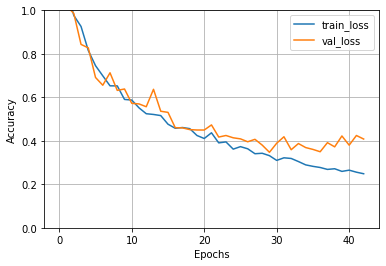

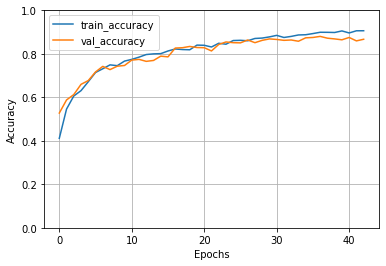

In [55]:
def plot_metrics(H, epoch, metric):
    plt.figure(figsize=(6, 4))
    # plot training loss or accuracy
    plt.plot(np.arange(0, epoch), H.history[f'{metric}'], label=f'train_{metric}')
    # plot validation loss or accuracy
    plt.plot(np.arange(0, epoch), H.history[f'val_{metric}'], label=f'val_{metric}')
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='Loss' else 'Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


plot_metrics(history,43,'loss')
plot_metrics(history,43,'accuracy')

In [26]:
model = keras.models.load_model('Model_Path/model1.h5')

model.evaluate(x=val_x , y=val_y)

38/38 [==============================] - 2s 20ms/step - loss: 0.2222 - accuracy: 0.9216


[0.22218313813209534, 0.9215524196624756]

## Save the model

In [53]:
os.mkdir('Model_Path')
model.save('./Model_Path/model1.h5')

In [ ]:
del model

## Test 

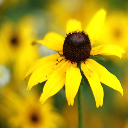

pred:black_eyed_susan,99.99%
real:black_eyed_susan



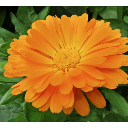

pred:calendula,98.4%
real:calendula



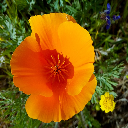

pred:california_poppy,99.66%
real:california_poppy



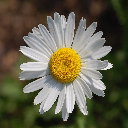

pred:common_daisy,99.99%
real:common_daisy



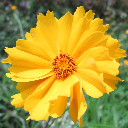

pred:coreopsis,96.8%
real:coreopsis



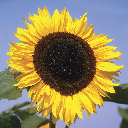

pred:sunflower,100.0%
real:sunflower



In [84]:
def preprocess(img_path):
  image = cv2.imread(img_path)    # load image from file
  image = cv2.resize(image, (128,128))    # make all images to have a same size
  cv2_imshow(image)       # Diplay photo
  image = image/255      # normalize pixel values
  return np.expand_dims(image, axis=0)


model = keras.models.load_model('Model_Path/model1.h5')

for img in classes:
  test_image_path = f'Test_Images/{img}.jpg'
  image = preprocess(test_image_path)

  y_pred = model.predict(image,verbose = 0)
  label_pred = classes[np.argmax(y_pred)]
  prob = np.round(y_pred[0][np.argmax(y_pred)]*100,2)

  print(f'pred:{label_pred},{prob}%\nreal:{img}\n')



# **Transfer Learning** 

### Use MobilenetV2 as a model

In [7]:
mobilenet_model = MobileNetV2(weights='imagenet',include_top=False,input_shape=(img_width, img_height, 3))

for layer in mobilenet_model.layers:
    layer.trainable = False

In [8]:
model = keras.Sequential([
    mobilenet_model,
    Flatten(),
    Dropout(0.2),
    Dense(units=100, activation='relu'),
    Dropout(0.2),
    Dense(len(classes), activation='softmax')
])
model.compile(optimizer='adam', 
                loss='categorical_crossentropy',
                metrics=['accuracy'])


In [11]:
Callbacks = [callbacks.EarlyStopping(monitor='val_accuracy', patience=6, verbose=0)]

history = model.fit_generator(train_datagen.flow(train_x,train_y, batch_size = batch_size), 
                              epochs = epochs,
                              callbacks = Callbacks,
                    validation_data=validation_datagen.flow(val_x,val_y, batch_size = batch_size),
                    )


<ipython-input-11-b47fc2fdc962>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(train_x,train_y, batch_size = batch_size),


Epoch 1/80
49/49 [==============================] - 34s 439ms/step - loss: 2.0831 - accuracy: 0.4648 - val_loss: 0.8772 - val_accuracy: 0.7159
Epoch 2/80
49/49 [==============================] - 20s 409ms/step - loss: 0.9534 - accuracy: 0.6872 - val_loss: 0.5921 - val_accuracy: 0.8200
Epoch 3/80
49/49 [==============================] - 21s 428ms/step - loss: 0.7391 - accuracy: 0.7520 - val_loss: 0.4852 - val_accuracy: 0.8415
Epoch 4/80
49/49 [==============================] - 20s 407ms/step - loss: 0.6574 - accuracy: 0.7846 - val_loss: 0.4319 - val_accuracy: 0.8571
Epoch 5/80
49/49 [==============================] - 21s 431ms/step - loss: 0.6150 - accuracy: 0.8061 - val_loss: 0.4007 - val_accuracy: 0.8753
Epoch 6/80
49/49 [==============================] - 20s 402ms/step - loss: 0.5737 - accuracy: 0.8063 - val_loss: 0.4056 - val_accuracy: 0.8613
Epoch 7/80
49/49 [==============================] - 21s 427ms/step - loss: 0.5301 - accuracy: 0.8247 - val_loss: 0.3763 - val_accuracy: 0.8794

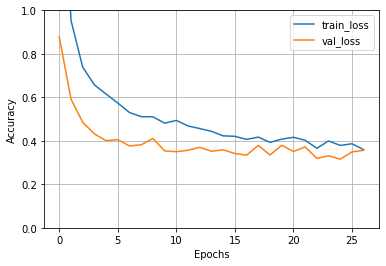

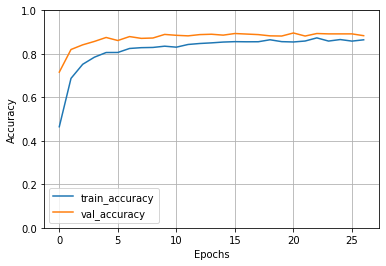

In [13]:
def plot_metrics(H, epoch, metric):
    plt.figure(figsize=(6, 4))
    # plot training loss or accuracy
    plt.plot(np.arange(0, epoch), H.history[f'{metric}'], label=f'train_{metric}')
    # plot validation loss or accuracy
    plt.plot(np.arange(0, epoch), H.history[f'val_{metric}'], label=f'val_{metric}')
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='Loss' else 'Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


plot_metrics(history,27,'loss')
plot_metrics(history,27,'accuracy')

In [19]:
model.evaluate(x=val_x , y=val_y)

38/38 [==============================] - 1s 22ms/step - loss: 0.1960 - accuracy: 0.9315


[0.19595879316329956, 0.9314615726470947]

## Save the model

In [21]:
model.save('./Model_Path/model2.h5')

In [23]:
del model

## Prediction

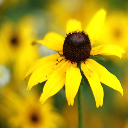

pred:black_eyed_susan,100.0%
real:black_eyed_susan



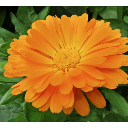

pred:calendula,99.62%
real:calendula



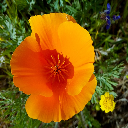

pred:california_poppy,80.86%
real:california_poppy



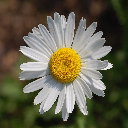

pred:common_daisy,99.95%
real:common_daisy



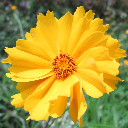

pred:coreopsis,99.36%
real:coreopsis



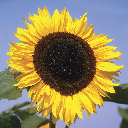

pred:sunflower,100.0%
real:sunflower



In [22]:
def preprocess(img_path):
  image = cv2.imread(img_path)    # load image from file
  image = cv2.resize(image, (128,128))    # make all images to have a same size
  cv2_imshow(image)       # Diplay photo
  image = image/255      # normalize pixel values
  return np.expand_dims(image, axis=0)


model = keras.models.load_model('Model_Path/model2.h5')

for img in classes:
  test_image_path = f'Test_Images/{img}.jpg'
  image = preprocess(test_image_path)

  y_pred = model.predict(image,verbose = 0)
  label_pred = classes[np.argmax(y_pred)]
  prob = np.round(y_pred[0][np.argmax(y_pred)]*100,2)
  
  print(f'pred:{label_pred},{prob}%\nreal:{img}\n')

